# Biodiversity Intactness Index change in Phoenix subdivision

### background
In 2021, Maricopa County, which encompasses the Phoenix metropolitan area, was the US county that added the most developed land since 2001 [1]. Urban sprawl creates pressure on biodiversity and natural areas. In this task you will explore a dataset showing values for a biodiversity intactness index (BII) [2, 3] to find changes in this BII around the Phoenix area from 2017 to 2020. 


Instructions

1. Data access:

- a: BII data: This dataset is part of the MPC STAC catalog. You will need to access the ‘io-biodiversity’ collection and look for the 2017 and 2020 rasters covering Phoenix subdivision. You can use the following coordinates for a bounding box: 
[-112.826843, 32.974108, -111.184387, 33.863574]
- b: Phoenix subdivision: You will find the Phoenix subdivision polygon in the Census County Subdivision shapefiles for Arizona: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions

2. Create a map showing the Phoenix subdivision within an appropriate geographical context. You may use any vector datasets to create your map. (You can also check out the contextily package.)

3. Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017. Obtain the same calculation for 2020. HINTS (useful or not depending on your workflow): Let x be an xarray.DataArray. We can select all the values greater than n by simply doing x>n. This will return an xarray.DataArray with boolean values. You can then transform this into an xarray.DataArray with 0s and 1s (instead of True/False) by casting it as type ‘int’. To calculate the percentage area: (pixels in class)/(total pixels) * 100. 

4. Create a visualization showing the area with BII>=0.75 in 2017 that was lost by 2020. Here’s an example:


In [189]:
#calling in all the packages i might need

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box

from rasterio.features import rasterize # for rasterizing polygons
from rasterio.features import shapes
import pystac_client
import planetary_computer
import matplotlib.patches as mpatches # for creating legends

# used to access STAC catalogs
from pystac_client import Client
# used to sign items from the MPC STAC catalog
import planetary_computer

from shapely.geometry import Polygon

# ----- other libraries for nice ouputs
from IPython.display import Image

from geogif import gif  # to create gif


In [90]:
#first going to call in arizona shapefile

In [91]:
ar = gpd.read_file('data/tl_2022_04_cousub.shp')
ar.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,NaN,NaN,NaN,S,12231052883,44653332,+35.1066114,-111.3662497,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,NaN,NaN,NaN,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,NaN,NaN,NaN,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."
3,04,023,92295,01934961,0402392295,Nogales,Nogales CCD,22,Z5,G4040,NaN,NaN,NaN,S,1762322938,2382710,+31.4956020,-111.0171332,"POLYGON ((-111.36692 31.52136, -111.36316 31.5..."
4,04,023,92550,01934966,0402392550,Patagonia,Patagonia CCD,22,Z5,G4040,NaN,NaN,NaN,S,1439530300,685527,+31.5664619,-110.6410279,"POLYGON ((-110.96273 31.68695, -110.96251 31.6..."


In [92]:
#now justchanging crs to make sure it looks good on epsg 4326
ar = ar.to_crs(4326)

In [93]:
ar.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

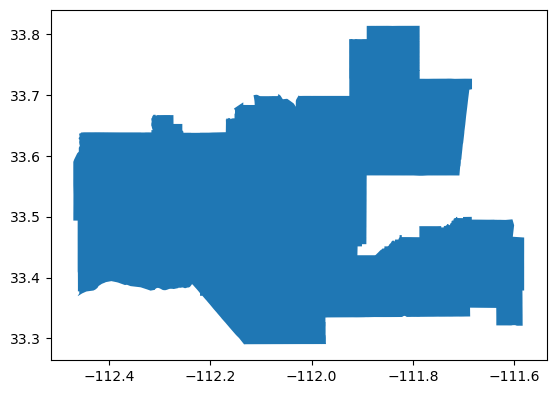

In [94]:
phoenix = ar[ar.NAME == 'Phoenix']
phoenix.plot()

In [95]:
catalog = pystac_client.Client.open(
    'https://planetarycomputer.microsoft.com/api/stac/v1',
    modifier=planetary_computer.sign_inplace,)

In [96]:
#info and bio, ask yutian if we need background info for this
bio_collection = catalog.get_child('io-biodiversity')
bio_collection

id: io-biodiversity
title: Biodiversity Intactness
"description: Generated by [Impact Observatory](https://www.impactobservatory.com/), in collaboration with [Vizzuality](https://www.vizzuality.com/), these datasets estimate terrestrial Biodiversity Intactness as 100-meter gridded maps for the years 2017-2020. Maps depicting the intactness of global biodiversity have become a critical tool for spatial planning and management, monitoring the extent of biodiversity across Earth, and identifying critical remaining intact habitat. Yet, these maps are often years out of date by the time they are available to scientists and policy-makers. The datasets in this STAC Collection build on past studies that map Biodiversity Intactness using the [PREDICTS database](https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.2579) of spatially referenced observations of biodiversity across 32,000 sites from over 750 studies. The approach differs from previous work by modeling the relationship between observed biodiversity metrics and contemporary, global, geospatial layers of human pressures, with the intention of providing a high resolution monitoring product into the future. Biodiversity intactness is estimated as a combination of two metrics: Abundance, the quantity of individuals, and Compositional Similarity, how similar the composition of species is to an intact baseline. Linear mixed effects models are fit to estimate the predictive capacity of spatial datasets of human pressures on each of these metrics and project results spatially across the globe. These methods, as well as comparisons to other leading datasets and guidance on interpreting results, are further explained in a methods [white paper](https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf) entitled “Global 100m Projections of Biodiversity Intactness for the years 2017-2020.” All years are available under a Creative Commons BY-4.0 license."
"providers: Impact Observatory (processor, producer, licensor) Vizzuality (processor) Microsoft (host)"
type: Collection
"item_assets: {'data': {'type': 'image/tiff; application=geotiff; profile=cloud-optimized', 'roles': ['data'], 'title': 'Biodiversity Intactness', 'description': 'Terrestrial biodiversity intactness at 100m resolution', 'raster:bands': [{'sampling': 'area', 'data_type': 'float32', 'spatial_resolution': 100}]}}"
msft:region: westeurope
msft:container: impact
msft:storage_account: pcdata01euw
msft:short_description: Global terrestrial biodiversity intactness at 100m resolution for years 2017-2020
https://stac-extensions.github.io/item-assets/v1.0.0/schema.json


In [97]:
# bounding box for search we are interessted with

bbox = [-112.826843, 32.974108, -111.184387, 33.863574]


In [98]:
# catalog search
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox)
search

In [99]:
#searching how many items are in the  collection
items = search.item_collection()
len(items) #there are 4 items!

4

In [100]:
items

id: bii_2020_34.74464974521749_-115.38597824385106_cog
"bbox: [-115.3859782, 27.565314, -108.2066425, 34.7446497]"
datetime: None
proj:epsg: 4326
"proj:shape: [7992, 7992]"
end_datetime: 2020-12-31T23:59:59Z
"proj:transform: [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0]"
start_datetime: 2020-01-01T00:00:00Z
https://stac-extensions.github.io/projection/v1.0.0/schema.json
https://stac-extensions.github.io/raster/v1.1.0/schema.json
https://stac-extensions.github.io/version/v1.1.0/schema.json


In [101]:
# get third item in the catalog search as that is for the year 2017
item_17 = items[3]
type(item_17)

pystac.item.Item

In [102]:
#just checking the properties for 2017
print('id:' , item_17.id)
item_17.properties

id: bii_2017_34.74464974521749_-115.38597824385106_cog


{'datetime': None,
 'proj:epsg': 4326,
 'proj:shape': [7992, 7992],
 'end_datetime': '2017-12-31T23:59:59Z',
 'proj:transform': [0.0008983152841195215,
  0.0,
  -115.38597824385106,
  0.0,
  -0.0008983152841195215,
  34.74464974521749,
  0.0,
  0.0,
  1.0],
 'start_datetime': '2017-01-01T00:00:00Z'}

In [103]:
#checking the key for items, as we want to pull it out and render it
for key in item_17.assets.keys():
    print(key, '--', item_17.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [104]:
# plot rendered preview
Image(url=item_17.assets['rendered_preview'].href, width=500)

# for year 2020

In [105]:
#and for the year 2020, we want to pull that out
item_20 = items[0]
type(item_20)

pystac.item.Item

In [106]:
#checking its properties
print('id:' , item_20.id)
item_20.properties

id: bii_2020_34.74464974521749_-115.38597824385106_cog


{'datetime': None,
 'proj:epsg': 4326,
 'proj:shape': [7992, 7992],
 'end_datetime': '2020-12-31T23:59:59Z',
 'proj:transform': [0.0008983152841195215,
  0.0,
  -115.38597824385106,
  0.0,
  -0.0008983152841195215,
  34.74464974521749,
  0.0,
  0.0,
  1.0],
 'start_datetime': '2020-01-01T00:00:00Z'}

In [107]:
#figure out the key
for key in item_20.assets.keys():
    print(key, '--', item_20.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [108]:
# plot rendered preview
Image(url=item_20.assets['rendered_preview'].href, width=500)

# extract
time to finally plot and extract data

In [109]:
#going to extract now the raster for 2017
az_17 = rioxr.open_rasterio(item_17.assets['data'].href)
az_17

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [110]:
#also extracting for the year 2020
az_20 = rioxr.open_rasterio(item_20.assets['data'].href)
az_20

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [111]:
# Since there is only one band, we want to squeeze and remove both for 2017 and 2020, since it will just be in the way

# remove length 1 dimension (band)
az_17 = az_17.squeeze().drop('band')

az_20 = az_20.squeeze().drop('band')


In [112]:
# But i have to remember that I want this clipped, so that the raster will show up quicker
az_17 = az_17.rio.clip_box(*phoenix.total_bounds)

az_20 = az_20.rio.clip_box(*phoenix.total_bounds)

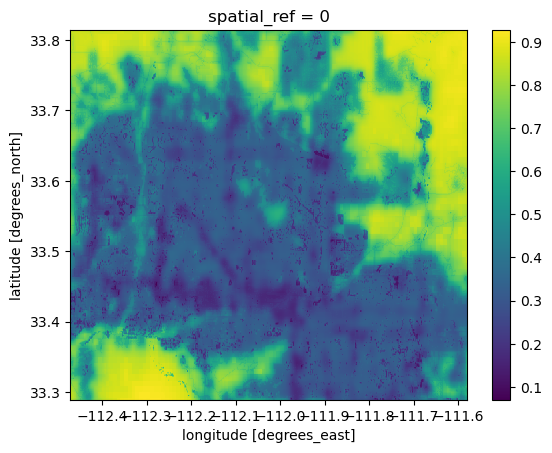

In [113]:
az_17.plot()

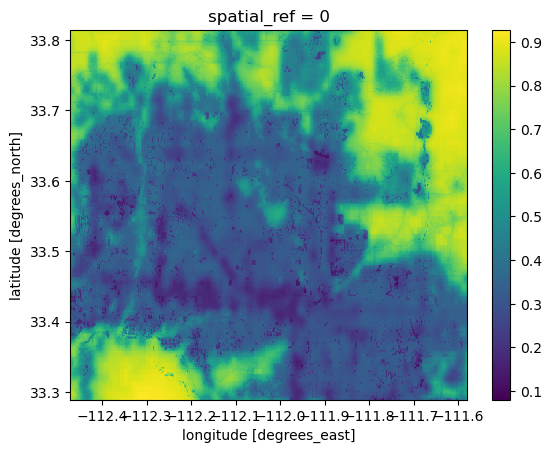

In [114]:
az_20.plot()

# Question 2

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

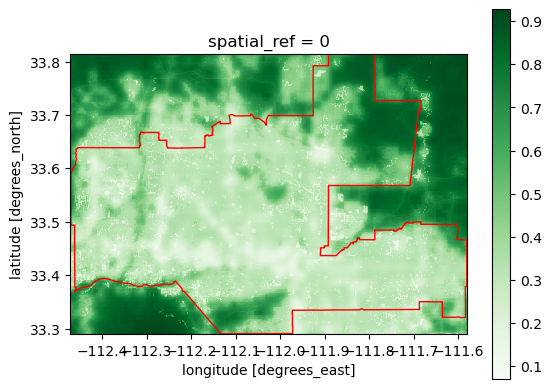

In [115]:
#now I want to make a map of Arizona in geographical context
fig, ax = plt.subplots()

az_17.plot(ax = ax,
                cmap = 'Greens'
               )
phoenix.plot(ax = ax,
             color = 'none',
             edgecolor = 'red'
            )

#title and make it prettier!

# For Question 3: map of Phoenix

In [116]:
#make a mask first
import xarray as xr
import rioxarray as rioxr

# create raster mask based on  polygon
phoenix_mask = rasterize(shapes = [phoenix.loc[10, 'geometry']],  # a list of geometries
                        out_shape = az_20.shape,           # shape of outout np array (shape of raster)
                        transform = az_20.rio.transform(), # transformation of raster ## change CRS and drop and squeeze# original dimensions and coordinates
                        all_touched = True)

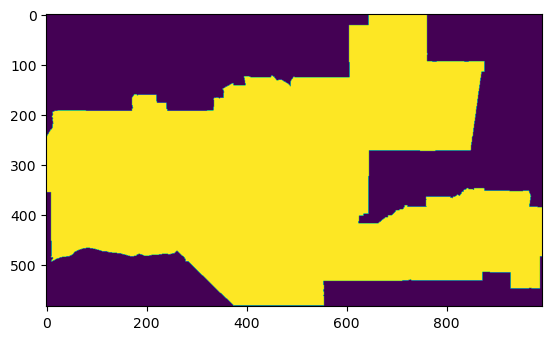

In [117]:
#view that my mask worked out
plt.imshow(phoenix_mask)

In [118]:
#going to apply my mask to my raster now
phoenix_bii_20 = az_20 * phoenix_mask
phoenix_bii_17 = az_17 * phoenix_mask

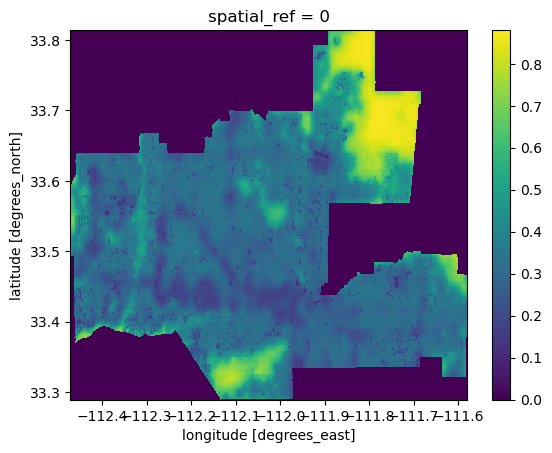

In [119]:
phoenix_bii_20.plot()

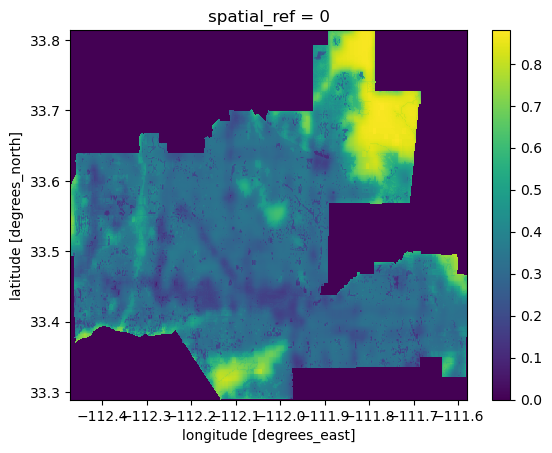

In [120]:
phoenix_bii_17.plot()

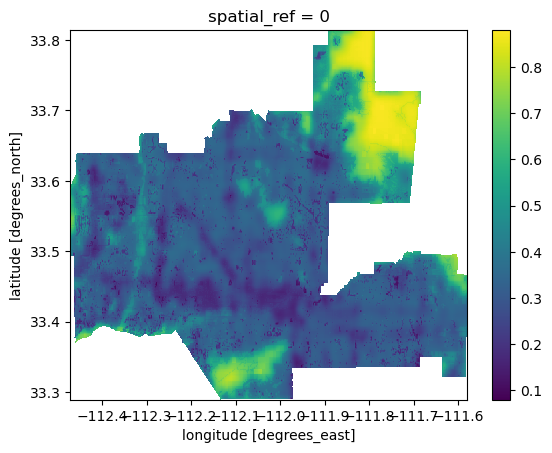

In [121]:
#Just going to remove the noise outside the raster data that i dont want
phoenix_bii_20 = phoenix_bii_20.where(phoenix_bii_20 != 0)
phoenix_bii_20.plot()

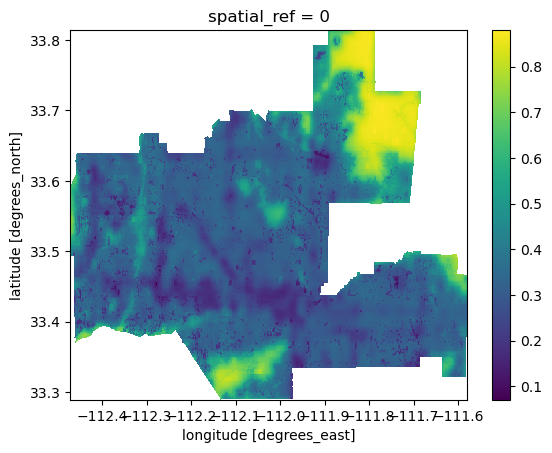

In [122]:
#same process with 2017
phoenix_bii_17 = phoenix_bii_17.where(phoenix_bii_17 != 0)
phoenix_bii_17.plot()

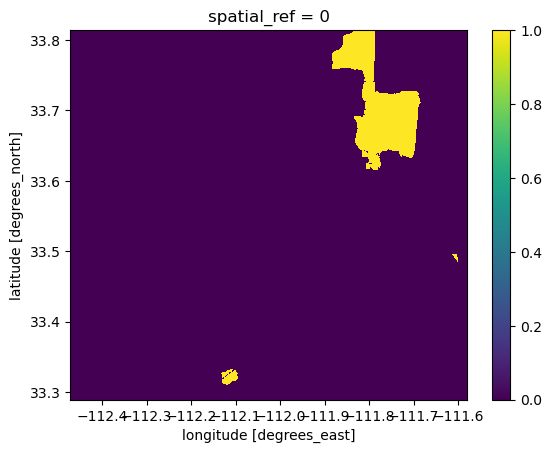

In [123]:
#now calculating where the BII is above 75 for 2020
phoenix_bii_2020=phoenix_bii_20 >= .75
phoenix_bii_2020.plot()

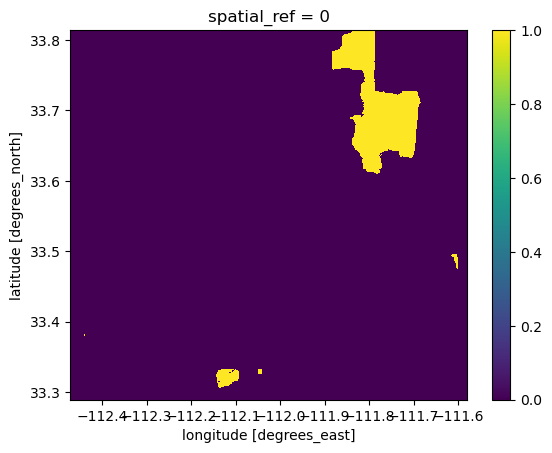

In [124]:
#same for 2017
phoenix_bii_2017=phoenix_bii_17 >= .75
phoenix_bii_2017.plot()

In [137]:
#percentage area for 2020 and 2017: first need to convert boolean to int
phoenix_bii_2020 = phoenix_bii_2020.astype('int64')
phoenix_bii_2017 = phoenix_bii_2017.astype('int64')

In [138]:
#now finding the percentage here
#(pixels in class)/(total pixels) * 100
Phoenix_bii_2020_per = (phoenix_bii_2020.sum().item()/phoenix_mask.sum().item()) * 100
Phoenix_bii_2017_per = (phoenix_bii_2017.sum().item()/phoenix_mask.sum().item()) * 100
print(Phoenix_bii_2017_per)
print(Phoenix_bii_2020_per)

7.1168424110981645
6.483516806019822


In [139]:
#subtracting to find the difference
Phoenix_bii_2020_per - Phoenix_bii_2017_per

-0.6333256050783422

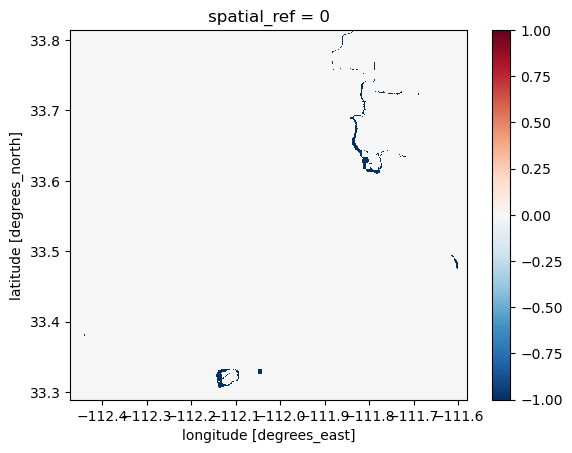

In [149]:
phoenix_bii_change = phoenix_bii_2020 - phoenix_bii_2017
phoenix_bii_change.plot()

In [199]:
#this will remove the noise i dont want in my plot
phoenix_bii_change = phoenix_bii_change.where(phoenix_bii_change != 0)

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


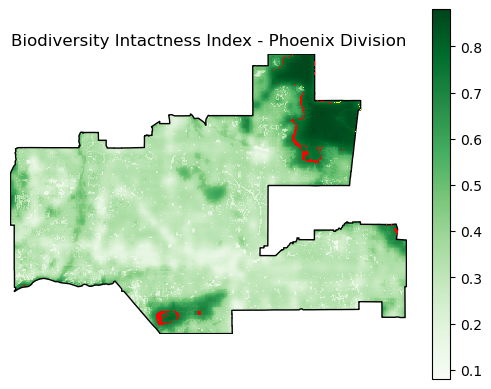

In [190]:
#final final map
fig, ax = plt.subplots()

phoenix_bii_20.plot(ax = ax,
                    cmap = 'Greens'    
                )
phoenix.plot(ax = ax,
             color = 'none',
             edgecolor = 'black'
            )
phoenix_bii_change.plot(ax = ax,
                        cmap = 'autumn',
                        add_colorbar = False
                       )
plt.axis('off')
plt.title('Biodiversity Intactness Index - Phoenix Division')
plt.show()
